In [108]:
import pandas as pd
import pysal as ps
import geopandas as gpd
import scipy
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from scipy.ndimage.interpolation import shift

import seaborn as sns
import matplotlib.pyplot as plt

def calculate_segregation(data, group_pop_var, total_pop_var):
    '''
    data: a geopandas DataFrame that contains a geometry column
    group_pop_var: the name of variable that contains the population size of the group of interest
    total_pop_var: the name of variable that contains the total population of the unit
    '''
    
    # Uneveness
    data = data.rename(columns={group_pop_var: 'group_pop_var', total_pop_var: 'total_pop_var'})
    data = data[['geometry', 'group_pop_var', 'total_pop_var']]
    T = data.total_pop_var.sum()
    P = data.group_pop_var.sum() / T
    data['ti'] = data.total_pop_var
    data['pi'] = data.group_pop_var / data.total_pop_var
    D = (((data.total_pop_var * abs(data.pi - P)))/ (2 * T * P * (1 - P))).sum()
    
    # Isolation
    data['xi'] = data.group_pop_var
    X = data['xi'].sum()
    data['yi'] = data.total_pop_var - data.group_pop_var
    xPx = ((data.xi / X) * (data.xi / data.ti)).sum()
    xPy = ((data.xi / X) * (data.yi / data.ti)).sum()
    
    CISO = xPx - X/T
    
    # Clustering
    Y = data.yi.sum()
    data['c_lons'] = data.centroid.map(lambda p: p.x)
    data['c_lats'] = data.centroid.map(lambda p: p.y)
    dist = euclidean_distances(data[['c_lons','c_lats']])
    np.fill_diagonal(dist, val = (0.6*data.area)**(1/2))
    c = np.exp(-dist)
    Pxx = ((np.array(data.xi) * c).T * np.array(data.xi)).sum() / X**2
    Pyy = ((np.array(data.yi) * c).T * np.array(data.yi)).sum() / Y**2
    Ptt = ((np.array(data.ti) * c).T * np.array(data.ti)).sum() / T**2
    
    SP = (X*Pxx + Y*Pyy)/(T*Ptt)
    RCL = Pxx / Pyy - 1

    # Concentration
    A = data.area.sum()
    DEL = 1/2 * abs(data.xi / X - data.area / A).sum()
    
    df_mp_sort_area = data
    df_mp_sort_area['area'] = df_mp_sort_area.area
    df_mp_sort_area_asc = df_mp_sort_area.sort_values('area')
    n1 = np.where(((np.cumsum(df_mp_sort_area_asc.ti) / T) < X/T) == False)[0][0]
    
    df_mp_sort_area_des = df_mp_sort_area.sort_values('area', ascending=False)
    n2 = np.where(((np.cumsum(df_mp_sort_area_des.ti) / T) < X/T) == False)[0][0]
    
    n = df_mp_sort_area_asc.shape[0]
    T1 =  df_mp_sort_area_asc.ti[0:(n1+1)].sum()
    T2 =  df_mp_sort_area_asc.ti[n2:n].sum()

    RCO = ((((df_mp_sort_area_asc.xi*df_mp_sort_area_asc.area/X).sum()) / ((df_mp_sort_area_asc.yi*df_mp_sort_area_asc.area/Y).sum())) - 1) / \
          ((((df_mp_sort_area_asc.ti*df_mp_sort_area_asc.area)[0:(n1+1)].sum() / T1) / ((df_mp_sort_area_asc.ti*df_mp_sort_area_asc.area)[n2:n].sum() / T2)) - 1)


    
    # Centralization
    data['center_lon']  = data.c_lons.mean()
    data['center_lat']  = data.c_lats.mean()
    data['center_dist'] = np.sqrt((data.c_lons - data.center_lon)**2 + (data.c_lats - data.center_lat)**2)
    data_sort_cent = data.sort_values('center_dist')
    
    data_sort_cent['Xi'] = np.cumsum(data_sort_cent.xi) / X
    data_sort_cent['Yi'] = np.cumsum(data_sort_cent.yi) / Y
    data_sort_cent['Ai'] = np.cumsum(data_sort_cent.area) / A
    
    ACE = (shift(data_sort_cent.Xi, 1, cval=np.NaN) * data_sort_cent.Ai).sum() - \
          (data_sort_cent.Xi * shift(data_sort_cent.Ai, 1, cval=np.NaN)).sum()
    
    RCE = (shift(data_sort_cent.Xi, 1, cval=np.NaN) * data_sort_cent.Yi).sum() - \
          (data_sort_cent.Xi * shift(data_sort_cent.Yi, 1, cval=np.NaN)).sum()
    
    # Aggregating
    SM = np.mean([D, CISO, RCL, RCO, RCE])
    
    return SM

census_2010 = pd.read_csv("data/std_2010_fullcount.csv", encoding = "ISO-8859-1", sep = ",")
df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10','tract','pop10','nhblk10']]
map_gpd = gpd.read_file("shapefiles/06065_Riverside_County.shp")
map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
df_map = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
df_mp = df_map[['geometry', 'pop10', 'nhblk10']]

In [109]:
df_mp.head()

,geometry,pop10,nhblk10
0,"POLYGON ((-117.319414 33.902109, -117.322528 3...",6242,677
1,"POLYGON ((-117.504056 33.800257, -117.502758 3...",10258,844
2,"POLYGON ((-117.472451 33.762031, -117.475661 3...",6342,405
3,"POLYGON ((-117.5285 33.89736, -117.529425 33.8...",2594,346
4,"POLYGON ((-117.501299 33.89424899999999, -117....",3586,429


In [107]:
p_null = df_mp.nhblk10.sum() / df_mp.pop10.sum()

In [95]:
def infer_segregation(data, group_pop_var, total_pop_var, permutations = 1000):
    '''
    data: a geopandas DataFrame that contains a geometry column
    group_pop_var: the name of variable that contains the population size of the group of interest
    total_pop_var: the name of variable that contains the total population of the unit
    permutations: number of permutation to compute inference on pseudo p-values
    '''
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', total_pop_var: 'total_pop_var'})
    p_null = data.group_pop_var.sum() / data.total_pop_var.sum()
    
    result_t = []
    for i in range(permutations):
        freq_sim = np.random.binomial(n = np.array([data.total_pop_var.tolist()]), 
                                      p = np.array([[p_null]*data.shape[0]]), 
                                      size = (1, data.shape[0])).tolist()[0]
        data['group_pop_var'] = freq_sim
        val = calculate_segregation(data, 'group_pop_var', 'total_pop_var')
        result_t.append(val)
    
    return result_t
    

In [96]:
actual_value = calculate_segregation(df_mp, 'nhblk10', 'pop10')
simulations =  infer_segregation(df_mp, 'nhblk10', 'pop10', permutations = 1000)

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


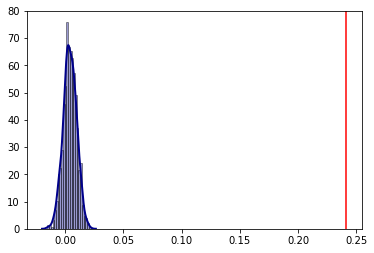

In [104]:
sns.distplot(simulations, 
             hist=True, 
             kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.axvline(actual_value, color = 'red')

In [90]:
actual_value

0.24143727444765